# DATA 602 Final Project

### Naomi Buell, Richie Rivera, Alexander Simon

## Abstract

[Insert abstract here. no more than 300 words.]

## Introduction

Our research question is: Is there a correlation between pain reliever misuse in US states and whether [states have expanded Medicaid](https://www.kff.org/affordable-care-act/issue-brief/status-of-state-medicaid-expansion-decisions-interactive-map/)? How has Medicaid expansion affected opioid misuse in the US? We plan to investigate the correlation between pain reliever misuse and states that have expanded Medicaid, and whether the rate of opioid misuse decreased after states expanded their Medicaid programs. We picked this topic because, as professionals in public health and biology, we are well aware of the toll that substance use disorders have taken, and the potential that Medicaid expansion under the Affordable Care Act (ACA) has to improve access to treatment for these disorders. 

We will obtain data on the prevalence of pain reliever misuse in each state from the [National Survey on Drug Use and Health (NSDUH)](https://datatools.samhsa.gov/nsduh/2019/nsduh-2018-2019-rd02yr/crosstab?row=PNRNMYR&column=STUSAB&weight=DASWT_1) from the Substance and Mental Health Services Administration (SAMHSA) and the status of each state’s decision on Medicaid expansion from [KFF](https://www.kff.org/affordable-care-act/issue-brief/status-of-state-medicaid-expansion-decisions-interactive-map/), a health policy organization. We will use the pandas and matplotlib libraries for our data analysis. Below is our exploratory data analysis and some summary statistics.

## Data Wrangling 

[Insert tidying of your data, manipulating missing values, structuring of
your data, etc.]

Our data are from the SAMHSA [National Survey on Drug Use and Health (NSDUH)](https://datatools.samhsa.gov/) 2-year restricted-use data sets for 2015-2016, 2016-17, 2017-18, 2018-19, and 2021-2022. No data related to our research question were available prior to 2015 (survey question of interest was not being asked yet) or for 2020 (likely due to COVID).

On the SAMHSA Data Tools webpage, we created "crosstabs" (data subsets) for the following variables and downloaded the CSV files:
-  PNRNMYR - During the past 12 months, if they misused prescription pain relievers
-  STUSAB - State US abbreviation

We also downloaded Medicaid expansion data (CSV) from [KFF](https://www.kff.org/affordable-care-act/issue-brief/status-of-state-medicaid-expansion-decisions-interactive-map/).

## Exploratory Data Analysis

[Insert EDA - well-labeled graphs/plots that are appropriate to your analysis. Each
visualization includes a description of what is being shown.]


### NSDUH Opioid Misuse Data

Below we import the NSDUH datasets, create dataframes, and explore this data.  

In [1]:
# Import libraries
import pandas as pd
import os
import re
import plotly.express as px
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy as np

# Set up filepaths
file_paths = [
    'data/STUSAB X PNRNMYR (2015-16).csv',
    'data/STUSAB X PNRNMYR (2016-17).csv',
    'data/STUSAB X PNRNMYR (2017-18).csv',
    'data/STUSAB X PNRNMYR (2018-19).csv',
    'data/STUSAB X PNRNMYR (2021-22).csv',
]

# Iterate over each path to add the CSV file to a list
df_collection = []
for path in file_paths:
    print(f'Reading in "{path}"')

    t_df = pd.read_csv(path)

    t_df['rpt_yr'] = pd.to_datetime(f'20{path[28:30]}-01-01')

    df_collection.append(
        t_df
    )

# Combine the collection of dataframes into one
df = pd.concat(df_collection)

print(df.head())

Reading in "data/STUSAB X PNRNMYR (2015-16).csv"
Reading in "data/STUSAB X PNRNMYR (2016-17).csv"
Reading in "data/STUSAB X PNRNMYR (2017-18).csv"
Reading in "data/STUSAB X PNRNMYR (2018-19).csv"
Reading in "data/STUSAB X PNRNMYR (2021-22).csv"
  STATE US ABBREVIATION RC-PAIN RELIEVERS - PAST YEAR MISUSE  Total %  \
0               Overall                              Overall    1.000   
1                    AK                              Overall    0.002   
2                    AL                              Overall    0.015   
3                    AR                              Overall    0.009   
4                    AZ                              Overall    0.021   

   Total % SE  Total % CI (lower)  Total % CI (upper)  Row %  Row % SE  \
0      0.0000                 NaN                 NaN    1.0       0.0   
1      0.0001               0.002               0.002    1.0       0.0   
2      0.0006               0.014               0.016    1.0       0.0   
3      0.0004       

Below, we print list of columns, length, number of non-missing observations, and data types.

In [2]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 155
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   STATE US ABBREVIATION                 780 non-null    object        
 1   RC-PAIN RELIEVERS - PAST YEAR MISUSE  780 non-null    object        
 2   Total %                               780 non-null    float64       
 3   Total % SE                            780 non-null    float64       
 4   Total % CI (lower)                    775 non-null    float64       
 5   Total % CI (upper)                    775 non-null    float64       
 6   Row %                                 780 non-null    float64       
 7   Row % SE                              780 non-null    float64       
 8   Row % CI (lower)                      520 non-null    float64       
 9   Row % CI (upper)                      520 non-null    float64       
 10  Column 

All 780 observations of the column `Count` are missing, but we can instead use the `Weighted Count` column for our analysis, so this is OK.<sup>[1](#footnote1)</sup> There are up to 260 missing observations in the columns of this dataset, however, our main variables of interest `STATE US ABBREVIATION`, `RC-PAIN RELIEVERS - PAST YEAR MISUSE`, and `Row %` are complete. We may also use `Row % CI (lower)` and `Row % CI (upper)`, which are 67% complete in the full dataset, but (as explored later) are 100% complete after we filter data down to observations of interest.

<sup id="footnote1">1</sup> Note that `Row %`s are rounded, so we may opt to calculate prevalence rates ourselves using `Weighted Count` for more precision.

Below are the means, medians, and other summary statistics of numeric columns.

In [3]:
# Summary statistics
df.describe()

,Total %,Total % SE,Total % CI (lower),Total % CI (upper),Row %,Row % SE,Row % CI (lower),Row % CI (upper),Column %,Column % SE,Column % CI (lower),Column % CI (upper),Weighted Count,Count,Count SE,rpt_yr
count,780.000000,780.000000,775.000000,775.000000,780.000000,780.000000,520.000000,520.000000,780.000000,780.000000,765.000000,765.000000,7.800000e+02,0.0,7.800000e+02,780
mean,0.025624,0.000510,0.018386,0.020391,0.666667,0.003592,0.489262,0.510738,0.038456,0.001267,0.017306,0.022429,7.013690e+06,NaN,1.666756e+05,2018-05-27 00:00:00
min,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.007000,0.022000,0.001000,0.000000,0.001000,0.002000,1.200000e+04,NaN,2.000000e+03,2016-01-01 00:00:00
25%,0.001000,0.000100,0.001000,0.001000,0.045000,0.000000,0.030000,0.050000,0.005000,0.000400,0.004000,0.006000,2.555000e+05,NaN,2.800000e+04,2017-01-01 00:00:00
50%,0.006000,0.000300,0.005000,0.006000,0.961000,0.004300,0.484000,0.516000,0.014000,0.000800,0.012000,0.016000,1.526000e+06,NaN,7.850000e+04,2018-01-01 00:00:00
75%,0.018000,0.000800,0.017000,0.020000,1.000000,0.005800,0.950000,0.970000,0.024250,0.001700,0.020000,0.028000,5.025000e+06,NaN,2.152500e+05,2019-01-01 00:00:00
max,1.000000,0.004300,0.968000,0.971000,1.000000,0.011800,0.978000,0.993000,1.000000,0.012300,0.118000,0.146000,2.809260e+08,NaN,3.041000e+06,2022-01-01 00:00:00
std,0.110711,0.000592,0.078245,0.078851,0.444593,0.002882,0.460170,0.460170,0.136495,0.001456,0.020440,0.024208,3.029175e+07,NaN,2.692497e+05,NaN


Here is a preview of our data after filtering down to just our columns and rows of interest.

In [4]:
# Selecting columns of interest from data
df_cols = df[['STATE US ABBREVIATION',
'RC-PAIN RELIEVERS - PAST YEAR MISUSE',
'Row %',
'Row % CI (lower)',
'Row % CI (upper)',
'Weighted Count',
'rpt_yr']]

# Subset the rows with states, removing the overall US observations
df_states = df_cols[df_cols['STATE US ABBREVIATION'] != "Overall"]

# Subset the rows where RC-PAIN RELIEVERS - PAST YEAR MISUSE = "1 - Misused within the past year" to get prevalence of opioid misuse
df_filtered = df_states[df_states['RC-PAIN RELIEVERS - PAST YEAR MISUSE'] == "1 - Misused within the past year"]

# Preview filtered data
df_filtered.head()


,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr
105,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016-01-01
106,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016-01-01
107,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016-01-01
108,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016-01-01
109,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016-01-01


Here are  summary statistics of our numeric variables in this filtered data frame.

In [5]:
# Show missingness of filtered data
print(df_filtered.info())

# Show summary statistics of filtered data
df_filtered.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 105 to 155
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   STATE US ABBREVIATION                 255 non-null    object        
 1   RC-PAIN RELIEVERS - PAST YEAR MISUSE  255 non-null    object        
 2   Row %                                 255 non-null    float64       
 3   Row % CI (lower)                      255 non-null    float64       
 4   Row % CI (upper)                      255 non-null    float64       
 5   Weighted Count                        255 non-null    int64         
 6   rpt_yr                                255 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 15.9+ KB
None


,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr
count,255.000000,255.000000,255.000000,2.550000e+02,255
mean,0.038808,0.029490,0.051329,2.045686e+05,2018-05-27 00:00:00
min,0.013000,0.007000,0.022000,1.200000e+04,2016-01-01 00:00:00
25%,0.033000,0.024000,0.044000,5.100000e+04,2017-01-01 00:00:00
50%,0.039000,0.030000,0.051000,1.540000e+05,2018-01-01 00:00:00
75%,0.045000,0.034000,0.058000,2.495000e+05,2019-01-01 00:00:00
max,0.065000,0.051000,0.083000,1.571000e+06,2022-01-01 00:00:00
std,0.008746,0.007924,0.010386,2.335462e+05,NaN


After filtering data, we have 100% completeness. States have, on average, 3.9% prevalence of opioid misuse in the past 12 months. 

### KFF State Medicaid Expansion Data

Below we import the KFF dataset and explore this data.  

In [6]:
# Import KFF data
path_kff = "data/raw_data_kff.xlsx"

df_kff = pd.read_excel(path_kff, skiprows=2)

df_kff.head()

,Location,Status of Medicaid Expansion Decision,Implemented Expansion On
0,Arizona,Adopted,2014-01-01 00:00:00
1,Arkansas,Adopted,2014-01-01 00:00:00
2,California,Adopted,2014-01-01 00:00:00
3,Colorado,Adopted,2014-01-01 00:00:00
4,Connecticut,Adopted,2014-01-01 00:00:00


We convert the state names to abbreviations to match NSDUH data.

In [7]:
# Create a dictionary with state names and their abbreviations as key:value pairs
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",  # Delete?
    "Guam": "GU",  # Delete?
    "Northern Mariana Islands": "MP",  # Delete?
    "Puerto Rico": "PR",
    "United States": "US",
}

# Map the state names in the KFF dataframe to the corresponding abbreviation
df_kff['Abbrev'] = df_kff['Location'].map(us_state_to_abbrev)

df_kff.head()

,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev
0,Arizona,Adopted,2014-01-01 00:00:00,AZ
1,Arkansas,Adopted,2014-01-01 00:00:00,AR
2,California,Adopted,2014-01-01 00:00:00,CA
3,Colorado,Adopted,2014-01-01 00:00:00,CO
4,Connecticut,Adopted,2014-01-01 00:00:00,CT


Below, we print the list of columns, length, number of non-missing observations, and data types.

In [8]:
# Info
df_kff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Location                               57 non-null     object
 1   Status of Medicaid Expansion Decision  52 non-null     object
 2   Implemented Expansion On               52 non-null     object
 3   Abbrev                                 52 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


We convert the `Implemented Expansion On` variable to a datetime datatype and summarize it below.

In [9]:
# Convert to datetime
df_kff['Implemented Expansion On'] = pd.to_datetime(df_kff['Implemented Expansion On'], errors='coerce')

# Range of dates
df_kff.describe()

,Implemented Expansion On
count,41
mean,2015-10-09 03:30:43.902438912
min,2014-01-01 00:00:00
25%,2014-01-01 00:00:00
50%,2014-01-01 00:00:00
75%,2016-01-01 00:00:00
max,2023-12-01 00:00:00


41 states expanded Medicaid so far (missing dates indicate that a state has not yet adopted Medicaid expansion). Most states who have expanded Medicaid did so on the first day of 2014. The last state to expand Medicaid, North Carolina, did so in December 2023.

Lastly, we'll combine the KFF and NSDUH data into one dataframe that we will perform our analysis on:

In [10]:
working_df = df_filtered.merge(
    df_kff,
    left_on = 'STATE US ABBREVIATION',
    right_on = 'Abbrev',
    how = 'left'
)

working_df.head()

,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev
0,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016-01-01,Alaska,Adopted,2015-09-01,AK
1,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016-01-01,Alabama,Not Adopted,NaT,AL
2,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016-01-01,Arkansas,Adopted,2014-01-01,AR
3,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016-01-01,Arizona,Adopted,2014-01-01,AZ
4,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016-01-01,California,Adopted,2014-01-01,CA


Perform some additional wrangling to faciliate analyses

In [11]:
# Add Boolean to indicate whether rates are post expansion (pre-expansion = False)
working_df['Post Expansion'] = working_df['rpt_yr'] >= working_df['Implemented Expansion On']
# Extract year from report datetime
working_df['rpt_yr'] = working_df['rpt_yr'].dt.year
# Scale the row % to make it easier to understand in the heatmaps
working_df['Scaled Row %'] = working_df['Row %'] * 100

working_df.head()

,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev,Post Expansion,Scaled Row %
0,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016,Alaska,Adopted,2015-09-01,AK,True,4.6
1,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016,Alabama,Not Adopted,NaT,AL,False,5.3
2,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016,Arkansas,Adopted,2014-01-01,AR,True,4.8
3,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016,Arizona,Adopted,2014-01-01,AZ,True,4.7
4,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016,California,Adopted,2014-01-01,CA,True,4.8


Pivot the 'Row %' column from long to wide so each report year is in its own column. This makes it easier to calculate the average OUD prevalence for each state.

In [12]:
# This cell contributed by Alex
# I divided working_df into expanded and not_expanded dataframes and pivoted them from long to wide

# States that expanded Medicaid
expanded_df = working_df[working_df['Implemented Expansion On'].notna()]
expanded_pivot_df = expanded_df.pivot(index = 'Abbrev', columns = 'rpt_yr', values = 'Scaled Row %').reset_index()
# Calculate average OUD rates during 2016-2019 (ie, before COVID)
expanded_pivot_df['Avg_2016_2019'] = expanded_pivot_df[[2016, 2017, 2018, 2019]].mean(axis = 1).round(1)
expanded_pivot_df['Expansion_status'] = 'Post-Expansion'
expanded_df.head()

# States that had not expanded Medicaid
not_expanded_df = working_df[working_df['Implemented Expansion On'].isna()]
not_expanded_pivot_df = not_expanded_df.pivot(index = 'Abbrev', columns = 'rpt_yr', values = 'Scaled Row %').reset_index()
# Calculate average OUD rates during 2016-2019
not_expanded_pivot_df['Avg_2016_2019'] = not_expanded_pivot_df[[2016, 2017, 2018, 2019]].mean(axis = 1).round(1)
not_expanded_pivot_df['Expansion_status'] = 'Pre-Expansion'

# Merge the dataframes
all_pivot_df = pd.concat([not_expanded_pivot_df, expanded_pivot_df], axis = 0)
print(all_pivot_df.head())

rpt_yr Abbrev  2016  2017  2018  2019  2022  Avg_2016_2019 Expansion_status
0          AL   5.3   4.4   5.2   5.3   4.9            5.0    Pre-Expansion
1          FL   4.0   4.4   4.6   3.9   2.2            4.2    Pre-Expansion
2          GA   3.8   3.2   3.5   3.5   2.8            3.5    Pre-Expansion
3          KS   4.2   4.6   3.9   4.0   3.2            4.2    Pre-Expansion
4          MS   4.5   4.0   4.6   4.4   3.6            4.4    Pre-Expansion


## Data Analysis

Below, we create a binary variable for whether the state OUD observation year occured after Medicaid expansion, called `post`.

In [13]:
working_df['post'] = working_df['rpt_yr'] >= working_df['Implemented Expansion On'].dt.year

working_df.head()

,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev,Post Expansion,Scaled Row %,post
0,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016,Alaska,Adopted,2015-09-01,AK,True,4.6,True
1,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016,Alabama,Not Adopted,NaT,AL,False,5.3,False
2,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016,Arkansas,Adopted,2014-01-01,AR,True,4.8,True
3,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016,Arizona,Adopted,2014-01-01,AZ,True,4.7,True
4,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016,California,Adopted,2014-01-01,CA,True,4.8,True


The histogram below shows the distribution of OUD prevalence rates in our dataset. We also fit the data to a normal distribution, which is overlaid on the histogram and indicates that the rates are approximately normally distributed.

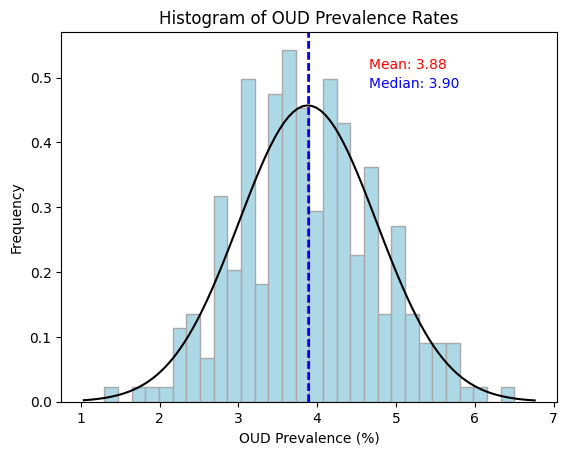

<Figure size 1000x600 with 0 Axes>

In [14]:
# This cell contributed by Alex
# Create histogram of OUD rates with a normal distribution for comparison

# Fit normal distribution to the data
mu, std = norm.fit(working_df['Scaled Row %']) 

# Plot histogram of OUD rates
plt.hist(working_df['Scaled Row %'], bins = 30, density = True, 
         color = 'lightblue', edgecolor = 'darkgray')
plt.axvline(working_df['Scaled Row %'].mean(), color = 'red', 
            linestyle = 'dashed')
plt.axvline(working_df['Scaled Row %'].median(), color = 'blue', 
            linestyle = 'dashed')

# Overlay normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k')

# Labels
min_ylim, max_ylim = plt.ylim()
plt.text(working_df['Scaled Row %'].mean() * 1.2, max_ylim * 0.9, 
         'Mean: {:.2f}'.format(working_df['Scaled Row %'].mean()), 
         color = 'red')
plt.text(working_df['Scaled Row %'].mean() * 1.2, max_ylim * 0.85, 
         'Median: {:.2f}'.format(working_df['Scaled Row %'].median()), 
         color = 'blue')
plt.xlabel('OUD Prevalence (%)')
plt.ylabel('Frequency')
plt.title('Histogram of OUD Prevalence Rates')

# View plot
plt.figure(figsize = (10, 6))
plt.show()

We created heatmaps (technically choropleth maps) of the average rates of opioid misuse during 2016-2019 (ie, pre-COVID) in states pre- and post- Medicaid expansion.

Pre-expansion (left plot), Alabama had the highest average rate of misuse (5.0%) and Wyoming had the average lowest rate (3.2%). Post-expansion (right plot), Oregon and Nevada had the highest average rate of misuse (5.4% for both). Maine and Nebraska had the lowest average rate of misuse (3.0% for both).

In [15]:
# Author: Alex

def draw_heatmap(df: pd.DataFrame, rate_column: str, 
                 facet_column: str, plots_per_row: int, title: str) -> px:
  '''
  This function takes a dataframe with OUD rates and 
  returns a choropleth map (ie, geographic heatmap)

  Args:
    df: Dataframe containing OUD prevalence rates
    rate_column: Name of column with OUD rates
    facet_column: Name of column with titles for each facet
    plots_per_row: Number of facets per row
    title: Main plot title
  
  Returns:
    heatmap: Plotly Express object
  '''
  heatmap = px.choropleth(df,
                        locations = 'Abbrev',
                        locationmode = "USA-states",
                        color = rate_column,
                        color_continuous_scale = 'rdbu_r',
                        labels = {rate_column : '% OUD'},
                        hover_name = 'Abbrev',
                        scope = 'usa',
                        facet_col = facet_column,
                        facet_col_wrap = plots_per_row)

  # Customize facets
  # Remove column name from title
  heatmap.for_each_annotation(lambda a: a.update(text = a.text.split("=")[-1]))
  # Adjust font size of title
  heatmap.update_annotations(font_size = 16)
  # Overall layout
  heatmap.update_layout(
      autosize = False,
      width = 1200,
      height = 600,
      title = {
          'text': title,
          'y' : 0.99,
          'x' : 0.5,
          'xanchor': 'center',
          'yanchor': 'top'},
      title_font_weight = 600)

  return heatmap

Note that the Plotly Express heatmaps are interactive. You can see information about individual states by hovering over it and zoom/pan each map.

In [16]:
# This cell contributed by Alex

# Compare average OUD rates pre vs post expansion
supertitle = 'Average OUD Prevalence During 2016-2019'
rate_column = 'Avg_2016_2019'
facet_column = 'Expansion_status'
plots_per_row = 2
avg_heatmap = draw_heatmap(all_pivot_df, rate_column, facet_column, plots_per_row, supertitle)
avg_heatmap.show()

We also created heatmaps for individual years to show the change in OUD prevalence over time pre- and post- expansion.

In general, OUD rates decreased from 2016 to 2022 in both pre-expansion states and post-expansion states, suggesting that the decline in OUD rates was not solely due to Medicaid expansion. In addition, a few pre-expansion states (eg, Alabama) and post-expansion states (eg, Nevada) had consistently high OUD rates over time.

In [17]:
# Author: Alex

# Annual changes in OUD rates pre-expansion
supertitle = 'OUD Prevalence Pre-Medicaid Expansion'
rate_column = 'Scaled Row %'
facet_column = 'rpt_yr'
plots_per_row = 3
pre_heatmap = draw_heatmap(not_expanded_df, rate_column, facet_column, plots_per_row, supertitle)
pre_heatmap.show()

In [18]:
# Author: Alex

# Annual changes in OUD rates post-expansion
supertitle = 'OUD Prevalence Post-Medicaid Expansion'
rate_column = 'Scaled Row %'
facet_column = 'rpt_yr'
plots_per_row = 3
post_heatmap = draw_heatmap(expanded_df, rate_column, facet_column, plots_per_row, supertitle)
post_heatmap.show()

We also make a scatter plot of state prevalence pre- and post-expansion.

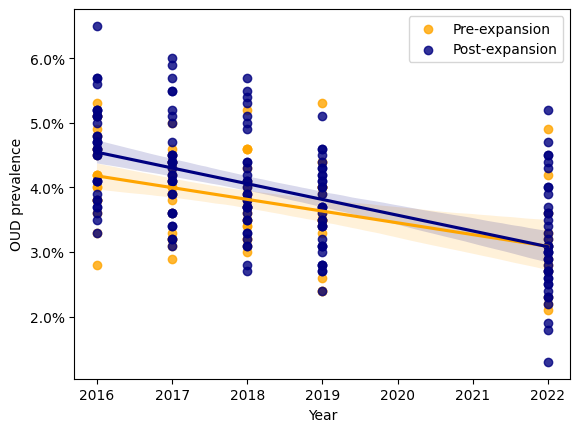

In [19]:
# Scatter plot

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Manipulate df prior to plotting
scatter_df = working_df.dropna(subset=['rpt_yr', 'Row %']) # Filter out rows with NaN values in columns of interest
scatter_df['rpt_yr'] = scatter_df['rpt_yr'] # Pulling just the year integer for graphing
scatter_df['Row %'] = scatter_df['Row %'] * 100

# Add trend lines
sns.regplot(data=scatter_df[scatter_df['post'] == 0], x='rpt_yr', y='Row %', scatter=True, color='orange', label='Pre-expansion')
sns.regplot(data=scatter_df[scatter_df['post'] == 1], x='rpt_yr', y='Row %', scatter=True, color='navy', label='Post-expansion')
sns.catplot # does jitter

# Add labels and title
plt.xlabel('Year')
plt.ylabel('OUD prevalence')
plt.gca().yaxis.set_major_formatter(PercentFormatter())  # Format y-axis as percentage
plt.legend()

# Show the plot
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression

# Create Xs (pre and post) from the year column values. Reshape X
X_pre = scatter_df[scatter_df['post'] == 0]['rpt_yr'].values.reshape(-1, 1)
X_post = scatter_df[scatter_df['post'] == 1]['rpt_yr'].values.reshape(-1, 1)

# Create y (pre and post) from the OUD rate column's values
y_pre= scatter_df[scatter_df['post'] == 0]['Row %'].values
y_post = scatter_df[scatter_df['post'] == 1]['Row %'].values

# Fit the model
model_pre = LinearRegression().fit(X_pre, y_pre) 
model_post = LinearRegression().fit(X_post, y_post) 

# Calculate R squared values
r2_pre = model_pre.score(X_pre, y_pre)
r2_post = model_post.score(X_post, y_post)

# Print the slopes and R squared values
print(f"Slope for Pre-expansion: {model_pre.coef_[0]}")
print(f"R squared for Pre-expansion: {r2_pre}")
print(f"Slope for Post-expansion: {model_post.coef_[0]}")
print(f"R squared for Post-expansion: {r2_post}")

Slope for Pre-expansion: -0.1816641104294477
R squared for Pre-expansion: 0.2137097466566641
Slope for Post-expansion: -0.24371126532000031
R squared for Post-expansion: 0.31028467739755394


The slope post-expansion is steeper than that for pre-expansion, suggesting that Medicaid expansion helps to decrease opioid misuse faster! This is a favorable sign for Medicaid expansion.

We will also try running a paired t-test to compare the means of pre- and post-expansion rates for the same states to assess whether the change in rates from pre- to post-expansion is significant. We need to verify the following assumptions:
- The dependent variable must be continuous interval or ratio. This is satisfied since the dependent variable, the interval or difference in OUD rate for a state pre- and post-expansion, is continuous from 0% to 100%.
- The observations are independent of one another. We can assume each states' OUD rate changes are independent from other states'.
- The dependent variable should be approximately normally distributed. Since we only have 8 data points of states with both pre and post data, we do **not** have enough data to satisfy this assumption. 
- The dependent variable should not contain any outliers. Based on our boxplot of the differences below, this assumption is satisfied.

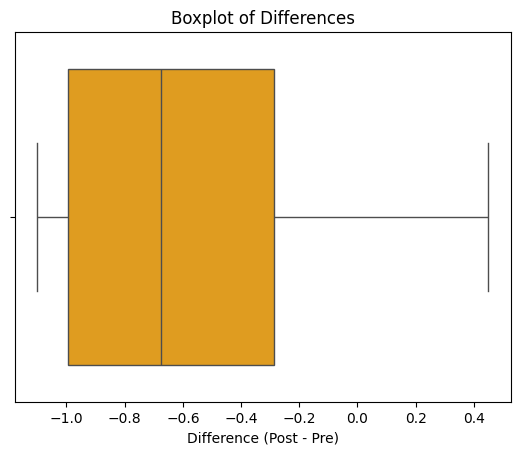

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Pivot the data to have one row per state with 'pre' and 'post' rates in separate columns
paired_df = scatter_df.pivot_table(index='Abbrev', columns='post', values='Row %')
paired_df.columns = ['Pre', 'Post']  # Rename columns for clarity
paired_df = paired_df.dropna()  # Drop states without both pre- and post-expansion data

# Calculate differences for paired t-test
paired_df['Difference'] = paired_df['Post'] - paired_df['Pre']

# Create boxplot to check for outliers
sns.boxplot(x=paired_df['Difference'], color='orange')
plt.title('Boxplot of Differences')
plt.xlabel('Difference (Post - Pre)')

plt.show()


We proceed with the test despite the small sample size. Note that we can't make a statistically meaningful conclusion given that our assumptions were not all satisfied.

In [22]:
from scipy.stats import ttest_rel

# Perform a paired t-test
t_stat_paired, p_value_paired = ttest_rel(paired_df['Pre'], paired_df['Post'])

# Prepare results for presentation
mean_pre = paired_df['Pre'].mean()
mean_post = paired_df['Post'].mean()
n_states = len(paired_df)

# Formatted output
print("Paired T-Test Results for Pre vs Post Medicaid Expansion OUD Rates")
print("-" * 60)
print(f"States with data: N = {n_states}")
print(f"Pre-Expansion: Mean = {mean_pre:.2f}%")
print(f"Post-Expansion: Mean = {mean_post:.2f}%")
print(f"T-Statistic = {t_stat_paired:.3f}")
print(f"P-Value = {p_value_paired:.3e}")

# Print interpretation of result based on p-value and alpha = .05:
if p_value_paired < 0.05:
    print("\nConclusion: The change in OUD rates from pre to post is statistically significant (p < 0.05).")
else:
    print("\nConclusion: The change in OUD rates from pre to post is not statistically significant (p ≥ 0.05).")


Paired T-Test Results for Pre vs Post Medicaid Expansion OUD Rates
------------------------------------------------------------
States with data: N = 7
Pre-Expansion: Mean = 3.77%
Post-Expansion: Mean = 3.21%
T-Statistic = 2.553
P-Value = 4.332e-02

Conclusion: The change in OUD rates from pre to post is statistically significant (p < 0.05).


The paired t-test results should be interpretted with caution as its assumptions weren't completely satisfied, but conclude that, for states who expanded Medicaid during our data timeframe, OUD rates did decline after expansion was implemented. 

# Richie's Plot

In [23]:
# Create a dataframe that omits states which have expansion before the oldest data(2016)
states_filtered = working_df.loc[working_df['Implemented Expansion On'] > '2016-01-01']

# Create a dataframe of average "Row %" before and after expansion for each state
avg_df = states_filtered[
    [
        'Location',
        'post',
        'Row %'
    ]
].groupby(['Location','post']).mean().reset_index().rename(
    columns = {
        'Row %' : 'opioid-misuse-pct',
        'Location' : 'State'
    }
)

avg_df.head()

,State,post,opioid-misuse-pct
0,Idaho,False,0.044750
1,Idaho,True,0.035000
2,Louisiana,True,0.045400
3,Maine,False,0.030667
4,Maine,True,0.020500


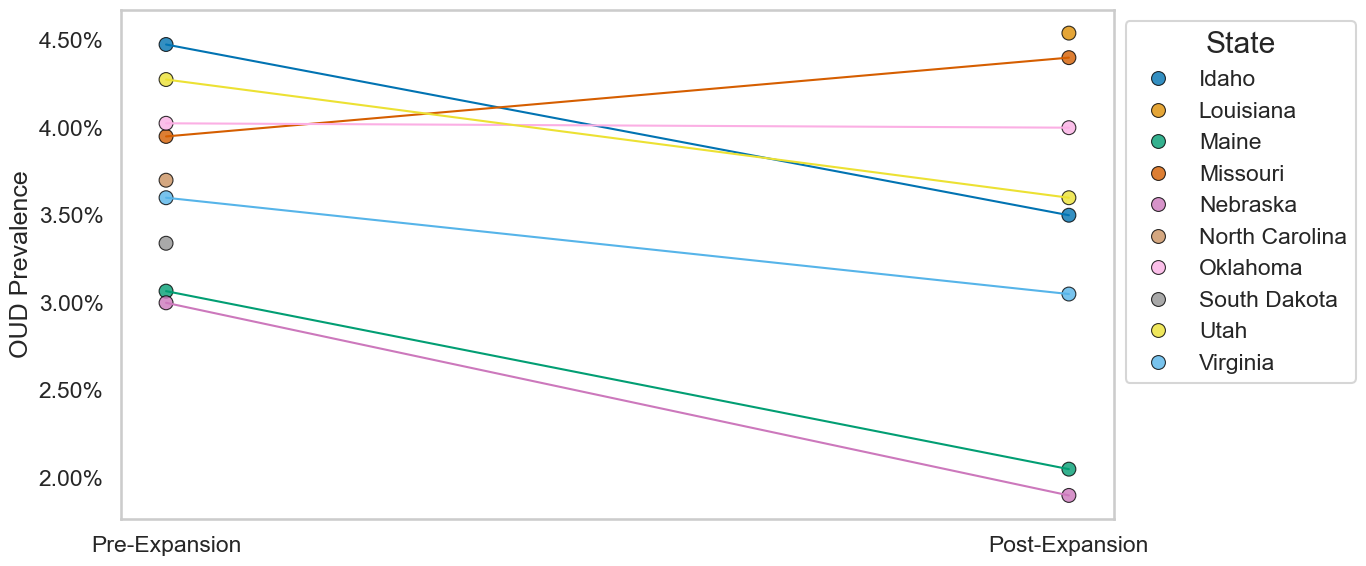

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Set a theme and larger font scale for readability
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context("talk")

# Create the figure and axis with a wider aspect ratio
fig, ax = plt.subplots(figsize=(14, 6))  # Wider figure size

# Create a scatter plot with the pre and post data
scatter = sns.scatterplot(
    data=avg_df,
    x='post',
    y='opioid-misuse-pct',
    hue='State',
    s=100,  # Increase marker size for visibility
    edgecolor='black',
    alpha=0.8  # Add transparency for a softer look
)

# Create a line to connect the dots
line = sns.lineplot(
    data=avg_df,
    x='post',
    y='opioid-misuse-pct',
    hue='State',
    estimator=None,
    palette='colorblind',
    legend=False,
    linewidth=1.5  # Thicker lines for better visibility
)

# Customize axis labels and ticks
ax.set(
    xlabel="",
    ylabel="OUD Prevalence",
    xticks=(0, 1),
    xticklabels=("Pre-Expansion", "Post-Expansion")
)
ax.yaxis.set_major_formatter(PercentFormatter(1))

# Adjust legend position and appearance
ax.legend(title="State", fontsize='medium', title_fontsize='large', frameon=True)
ax.grid(False)
sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))

# Tight layout to reduce overlap
plt.tight_layout()

# Display the plot
plt.show()


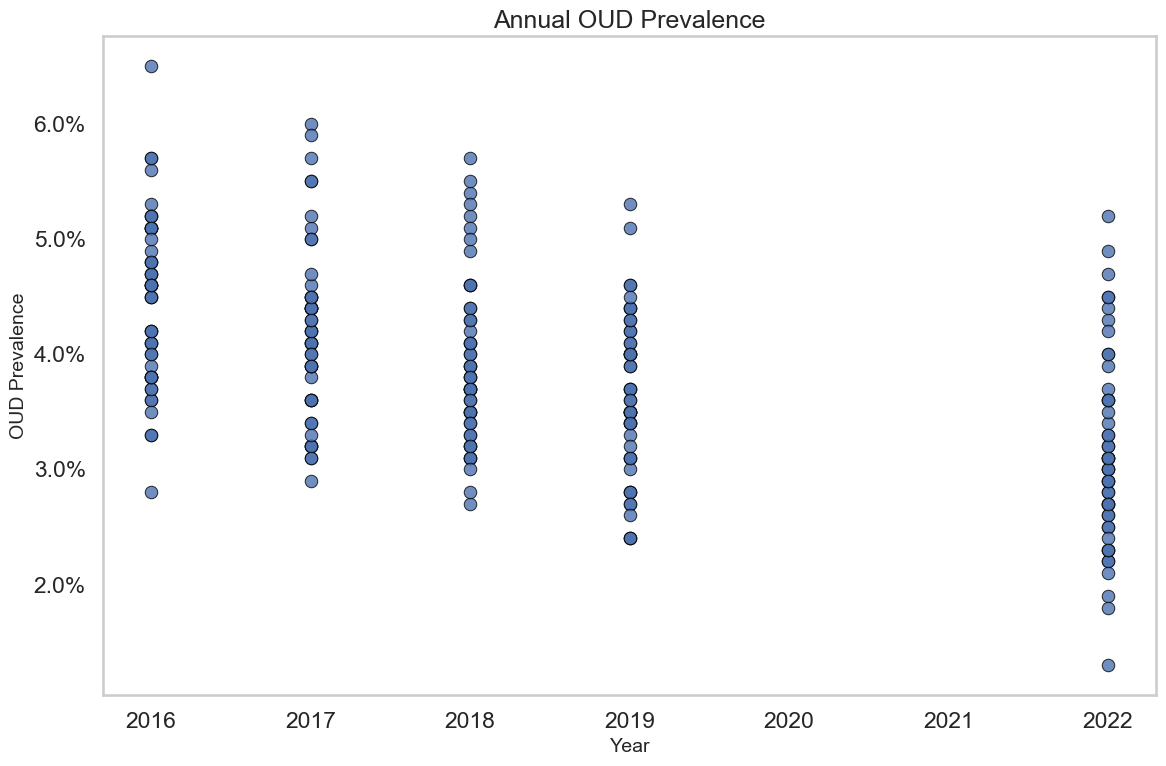

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a theme and larger font scale for better aesthetics
sns.set_theme(style="whitegrid", palette="deep")
sns.set_context("talk")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size

# Create the scatter plot
scatter = sns.scatterplot(
    data=df_filtered,
    x='rpt_yr',
    y='Row %',
    alpha=0.8,       # Transparency for better overlap visibility
    edgecolor='black'
)

ax.yaxis.set_major_formatter(PercentFormatter(1))

# Add titles and labels
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("OUD Prevalence", fontsize=14)
ax.set_title("Annual OUD Prevalence")
ax.grid(False)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


In [26]:
df_filtered.describe()

,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr
count,255.000000,255.000000,255.000000,2.550000e+02,255
mean,0.038808,0.029490,0.051329,2.045686e+05,2018-05-27 00:00:00
min,0.013000,0.007000,0.022000,1.200000e+04,2016-01-01 00:00:00
25%,0.033000,0.024000,0.044000,5.100000e+04,2017-01-01 00:00:00
50%,0.039000,0.030000,0.051000,1.540000e+05,2018-01-01 00:00:00
75%,0.045000,0.034000,0.058000,2.495000e+05,2019-01-01 00:00:00
max,0.065000,0.051000,0.083000,1.571000e+06,2022-01-01 00:00:00
std,0.008746,0.007924,0.010386,2.335462e+05,NaN


## Conclusion

[Insert]